In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import time
from datasets import load_dataset
from PIL import Image
from torchvision import transforms
from typing import Dict, Tuple
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Loading Data from the .json files and converting to .csv file

In [2]:
# Convert .jsn file to .csv
import json
mscoco_train2014_que = json.load(open(f'/kaggle/input/visual-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json','r'))
mscoco_train2014_ans = json.load(open(f'/kaggle/input/visual-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json','r'))

mscoco_train2014_que_df = pd.DataFrame(mscoco_train2014_que['questions'])
mscoco_train2014_ans_df = pd.DataFrame(mscoco_train2014_ans['annotations'])

mscoco_train2014 = pd.merge(mscoco_train2014_que_df, mscoco_train2014_ans_df, on=["image_id", "question_id"])

cols = ['image_id','question_id','question','question_type','multiple_choice_answer','answers','answer_type']
mscoco_train2014 = mscoco_train2014[cols]


#convert image_id to image_path
def image_id_to_path(subset,image_id):
    imdir='/kaggle/input/visual-question-answering/train2014/%s/COCO_%s_%012d.jpg'
    image_path = imdir%(subset, subset, image_id)
    return image_path

subset = 'train2014'
image_path = []
for i in (range(len(mscoco_train2014))):
    image_path.append(image_id_to_path(subset,mscoco_train2014['image_id'][i]))
mscoco_train2014['image_id'] = image_path


#create a list of multiple answers of an question
answers_list = []
for i in (range(len(mscoco_train2014))):
    ans_list = []
    for dic in (mscoco_train2014['answers'][i]):
        ans_list.append(dic['answer'])
    answers_list.append(ans_list)
mscoco_train2014['answers'] = answers_list

# save dataframe to .csv
mscoco_train2014.to_csv("/kaggle/working/mscoco_train2014.csv",index=False)


In [3]:
mscoco_train2014_que_df

,image_id,question,question_id
0,458752,What is this photo taken looking through?,458752000
1,458752,What position is this man playing?,458752001
2,458752,What color is the players shirt?,458752002
3,458752,Is this man a professional baseball player?,458752003
4,262146,What color is the snow?,262146000
...,...,...,...
443752,524286,What color is the keyboard?,524286001
443753,524286,Is there a computer mouse on the desk?,524286002
443754,524286,What color is the computer?,524286003
443755,524286,Why are there two keyboards?,524286004


In [4]:
mscoco_train2014_ans_df

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,what is this,net,"[{'answer': 'net', 'answer_confidence': 'maybe...",458752,other,458752000
1,what,pitcher,"[{'answer': 'pitcher', 'answer_confidence': 'y...",458752,other,458752001
2,what color is the,orange,"[{'answer': 'orange', 'answer_confidence': 'ye...",458752,other,458752002
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",458752,yes/no,458752003
4,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",262146,other,262146000
...,...,...,...,...,...,...
443752,what color is the,black,"[{'answer': 'black', 'answer_confidence': 'yes...",524286,other,524286001
443753,is there a,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",524286,yes/no,524286002
443754,what color is the,black,"[{'answer': 'black', 'answer_confidence': 'yes...",524286,other,524286003
443755,why,one is easier to type on,"[{'answer': 'don't know', 'answer_confidence':...",524286,other,524286004


In [5]:
mscoco_train2014

,image_id,question_id,question,question_type,multiple_choice_answer,answers,answer_type
0,/kaggle/input/visual-question-answering/train2...,458752000,What is this photo taken looking through?,what is this,net,"[net, net, net, netting, net, net, mesh, net, ...",other
1,/kaggle/input/visual-question-answering/train2...,458752001,What position is this man playing?,what,pitcher,"[pitcher, catcher, pitcher, pitcher, pitcher, ...",other
2,/kaggle/input/visual-question-answering/train2...,458752002,What color is the players shirt?,what color is the,orange,"[orange, orange, orange, orange, orange, orang...",other
3,/kaggle/input/visual-question-answering/train2...,458752003,Is this man a professional baseball player?,is this,yes,"[yes, yes, yes, yes, yes, no, yes, yes, yes, yes]",yes/no
4,/kaggle/input/visual-question-answering/train2...,262146000,What color is the snow?,what color is the,white,"[white, white, white, white, white, white, whi...",other
...,...,...,...,...,...,...,...
443752,/kaggle/input/visual-question-answering/train2...,524286001,What color is the keyboard?,what color is the,black,"[black, black, black, black, black, black, bla...",other
443753,/kaggle/input/visual-question-answering/train2...,524286002,Is there a computer mouse on the desk?,is there a,no,"[no, no, no, no, no, no, no, no, no, no]",yes/no
443754,/kaggle/input/visual-question-answering/train2...,524286003,What color is the computer?,what color is the,black,"[black, black, black, black, black, black, bla...",other
443755,/kaggle/input/visual-question-answering/train2...,524286004,Why are there two keyboards?,why,one is easier to type on,"[don't know, in case one keyboard breaks, for ...",other


In [6]:
mscoco_train2014.shape

(443757, 7)

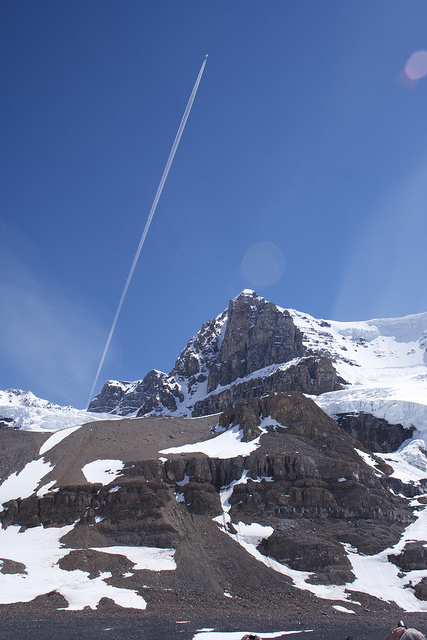

In [7]:
from IPython.display import Image

# Display the image inline
Image(filename=mscoco_train2014['image_id'][12])


## Sampling the data to get 1/4th of the training images

In [8]:
# Group the dataset by image_id and count the number of questions per image
image_counts = mscoco_train2014.groupby('image_id').size().reset_index(name='count')
image_counts

,image_id,count
0,/kaggle/input/visual-question-answering/train2...,3
1,/kaggle/input/visual-question-answering/train2...,18
2,/kaggle/input/visual-question-answering/train2...,6
3,/kaggle/input/visual-question-answering/train2...,3
4,/kaggle/input/visual-question-answering/train2...,3
...,...,...
82778,/kaggle/input/visual-question-answering/train2...,3
82779,/kaggle/input/visual-question-answering/train2...,6
82780,/kaggle/input/visual-question-answering/train2...,3
82781,/kaggle/input/visual-question-answering/train2...,4


In [9]:
image_counts.shape

(82783, 2)

In [10]:
sampled_image_ids = image_counts.sample(frac=0.25, random_state=42)['image_id']
sampled_image_ids

62467    /kaggle/input/visual-question-answering/train2...
71902    /kaggle/input/visual-question-answering/train2...
72054    /kaggle/input/visual-question-answering/train2...
68326    /kaggle/input/visual-question-answering/train2...
61942    /kaggle/input/visual-question-answering/train2...
                               ...                        
65914    /kaggle/input/visual-question-answering/train2...
48148    /kaggle/input/visual-question-answering/train2...
58872    /kaggle/input/visual-question-answering/train2...
73164    /kaggle/input/visual-question-answering/train2...
51208    /kaggle/input/visual-question-answering/train2...
Name: image_id, Length: 20696, dtype: object

In [11]:
sampled_image_ids.shape

(20696,)

In [12]:
# Filter the dataset to keep only the rows corresponding to the sampled image_ids
train_df = mscoco_train2014[mscoco_train2014['image_id'].isin(sampled_image_ids)]
train_df

,image_id,question_id,question,question_type,multiple_choice_answer,answers,answer_type
4,/kaggle/input/visual-question-answering/train2...,262146000,What color is the snow?,what color is the,white,"[white, white, white, white, white, white, whi...",other
5,/kaggle/input/visual-question-answering/train2...,262146001,What is the person doing?,what is the person,skiing,"[skiing, skiing, skiing, skiing, skiing, skiin...",other
6,/kaggle/input/visual-question-answering/train2...,262146002,What color is the persons headwear?,what color is the,red,"[red, red, red & white, black, red, red, red, ...",other
10,/kaggle/input/visual-question-answering/train2...,393221000,Is the sky blue?,is the,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
11,/kaggle/input/visual-question-answering/train2...,393221001,Is there snow on the mountains?,is there,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
...,...,...,...,...,...,...,...
443719,/kaggle/input/visual-question-answering/train2...,393195002,Is the woman wearing glasses?,is the woman,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
443744,/kaggle/input/visual-question-answering/train2...,262136000,Can he be sharpening blades?,none of the above,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
443745,/kaggle/input/visual-question-answering/train2...,262136001,How heavy is this man?,how,150 pounds,"[medium heaviness, 170 pounds, 200, not heavy,...",number
443746,/kaggle/input/visual-question-answering/train2...,262136002,Is this a normal thing to see in recent history?,is this a,no,"[no, no, no, yes, no, no, no, no, no, no]",yes/no


In [13]:
train_df.shape

(110247, 7)

In [14]:
# Filter rows based on the particular value of the column
filtered_df = train_df[train_df['answer_type'] == 'number']

# Display the filtered DataFrame
filtered_df

,image_id,question_id,question,question_type,multiple_choice_answer,answers,answer_type
182,/kaggle/input/visual-question-answering/train2...,131128002,How many flowers are painted on the vase?,how many,3,"[3, 3, 3, 3, 3, 3, 3, 6, 3, 2]",number
189,/kaggle/input/visual-question-answering/train2...,370986001,How many elephants are in the water?,how many,2,"[2, 2, 1, 2, 2, 2, 3, 2, 2, 2]",number
190,/kaggle/input/visual-question-answering/train2...,370986002,How many tails can you see in this picture?,how many,3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",number
207,/kaggle/input/visual-question-answering/train2...,458763001,How many trees on the table?,how many,3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",number
208,/kaggle/input/visual-question-answering/train2...,458763002,How many horns are in the picture?,how many,0,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 1]",number
...,...,...,...,...,...,...,...
443639,/kaggle/input/visual-question-answering/train2...,524249001,How many suitcases are there?,how many,7,"[7, 7, 7, 7, 8, 7, 7, 7, 6, 6]",number
443642,/kaggle/input/visual-question-answering/train2...,524249004,How many suitcases?,how many,7,"[7, 6, 7, 7, 7, 6, 7, 7, 6, 7]",number
443644,/kaggle/input/visual-question-answering/train2...,393178001,What is the number on the sign?,what is the,40,"[40, 40, 40, 40, 40, 40, 40, 40, 40, 40]",number
443645,/kaggle/input/visual-question-answering/train2...,393178002,How many train cars are there?,how many,2,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 1]",number


In [15]:
distinct_values = train_df['multiple_choice_answer'].unique()

In [16]:
distinct_values.shape

(9069,)

In [17]:
train_df.isna().sum()

image_id                  0
question_id               0
question                  0
question_type             0
multiple_choice_answer    0
answers                   0
answer_type               0
dtype: int64

In [18]:
answer = list(train_df['multiple_choice_answer'])

In [19]:
import string
def find_punctuation(text):
    punctuation_list = []
    for t in text:
        for i in t:
            if i in string.punctuation:  
                punctuation_list.append(i)
    punctuation_list = list(set(punctuation_list))
    return punctuation_list

ans_punct_list = find_punctuation(answer)
print(f'{len(ans_punct_list)} punctuations found in the Answer Dataset:\n{ans_punct_list}')

17 punctuations found in the Answer Dataset:
['%', ',', '_', "'", ')', '&', '@', '?', '.', '-', ':', '/', '#', '!', '(', '$', '"']


In [20]:
# Split each value in the column into words
words = train_df['multiple_choice_answer'].str.split()

# Filter values that are not one-word
not_one_word_values = train_df.loc[words.apply(len) != 1, 'multiple_choice_answer']

# Print the values that are not one-word
print(not_one_word_values)

14        white and purple
15          brushing teeth
173          sierra nevada
180       yellow and white
181       yellow and white
                ...       
443575             in bowl
443598      white and blue
443600       mubarak fahad
443745          150 pounds
443747    sharpening knife
Name: multiple_choice_answer, Length: 7942, dtype: object


## Preprocessing the text data of question and answer

In [21]:
import re
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)
    
    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def text_preprocess(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

def text_preprocess_ans(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9.! ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

In [22]:
train_df["question_preprocessed"] = train_df["question"].map(lambda x: text_preprocess(x))
train_df["answer_preprocessed"] = train_df["multiple_choice_answer"].map(lambda x: text_preprocess_ans(x))

/tmp/ipykernel_33/3694025488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["question_preprocessed"] = train_df["question"].map(lambda x: text_preprocess(x))
/tmp/ipykernel_33/3694025488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["answer_preprocessed"] = train_df["multiple_choice_answer"].map(lambda x: text_preprocess_ans(x))


In [23]:
train_df

,image_id,question_id,question,question_type,multiple_choice_answer,answers,answer_type,question_preprocessed,answer_preprocessed
4,/kaggle/input/visual-question-answering/train2...,262146000,What color is the snow?,what color is the,white,"[white, white, white, white, white, white, whi...",other,what color is the snow,white
5,/kaggle/input/visual-question-answering/train2...,262146001,What is the person doing?,what is the person,skiing,"[skiing, skiing, skiing, skiing, skiing, skiin...",other,what is the person doing,skiing
6,/kaggle/input/visual-question-answering/train2...,262146002,What color is the persons headwear?,what color is the,red,"[red, red, red & white, black, red, red, red, ...",other,what color is the persons headwear,red
10,/kaggle/input/visual-question-answering/train2...,393221000,Is the sky blue?,is the,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,is the sky blue,yes
11,/kaggle/input/visual-question-answering/train2...,393221001,Is there snow on the mountains?,is there,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,is there snow on the mountains,yes
...,...,...,...,...,...,...,...,...,...
443719,/kaggle/input/visual-question-answering/train2...,393195002,Is the woman wearing glasses?,is the woman,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,is the woman wearing glasses,yes
443744,/kaggle/input/visual-question-answering/train2...,262136000,Can he be sharpening blades?,none of the above,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,can he be sharpening blades,yes
443745,/kaggle/input/visual-question-answering/train2...,262136001,How heavy is this man?,how,150 pounds,"[medium heaviness, 170 pounds, 200, not heavy,...",number,how heavy is this man,150 pounds
443746,/kaggle/input/visual-question-answering/train2...,262136002,Is this a normal thing to see in recent history?,is this a,no,"[no, no, no, yes, no, no, no, no, no, no]",yes/no,is this a normal thing to see in recent history,no


In [24]:
train_df = train_df.drop(['question', 'multiple_choice_answer'], axis=1)

cols = ['image_id','question_id','question_preprocessed','question_type','answer_preprocessed','answers','answer_type']
train_df = train_df[cols]

train_df

,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type
4,/kaggle/input/visual-question-answering/train2...,262146000,what color is the snow,what color is the,white,"[white, white, white, white, white, white, whi...",other
5,/kaggle/input/visual-question-answering/train2...,262146001,what is the person doing,what is the person,skiing,"[skiing, skiing, skiing, skiing, skiing, skiin...",other
6,/kaggle/input/visual-question-answering/train2...,262146002,what color is the persons headwear,what color is the,red,"[red, red, red & white, black, red, red, red, ...",other
10,/kaggle/input/visual-question-answering/train2...,393221000,is the sky blue,is the,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
11,/kaggle/input/visual-question-answering/train2...,393221001,is there snow on the mountains,is there,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
...,...,...,...,...,...,...,...
443719,/kaggle/input/visual-question-answering/train2...,393195002,is the woman wearing glasses,is the woman,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
443744,/kaggle/input/visual-question-answering/train2...,262136000,can he be sharpening blades,none of the above,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
443745,/kaggle/input/visual-question-answering/train2...,262136001,how heavy is this man,how,150 pounds,"[medium heaviness, 170 pounds, 200, not heavy,...",number
443746,/kaggle/input/visual-question-answering/train2...,262136002,is this a normal thing to see in recent history,is this a,no,"[no, no, no, yes, no, no, no, no, no, no]",yes/no


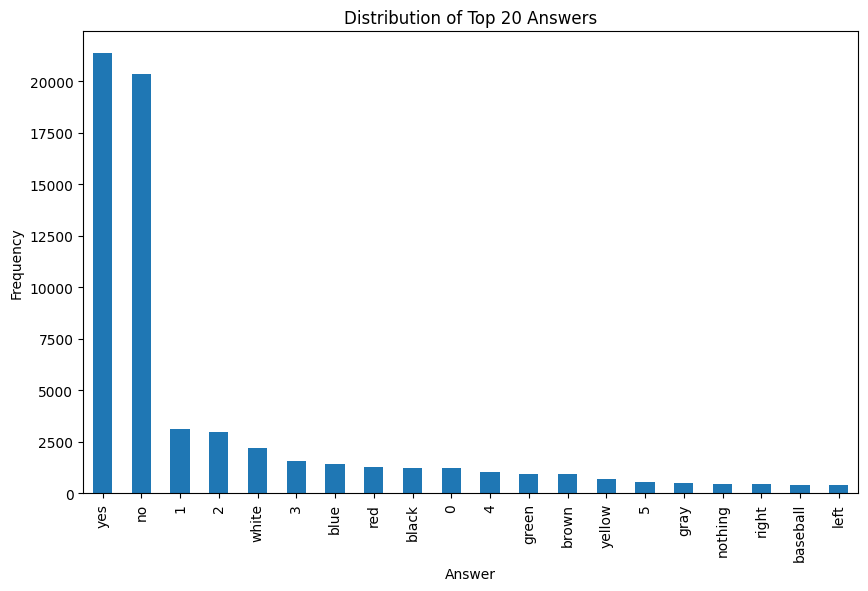

63170


In [25]:
import matplotlib.pyplot as plt

answer_frequency = train_df['answer_preprocessed'].value_counts()

# Select the top 20 answers based on frequency
top_20_answers = answer_frequency.head(20)

# Plot the distribution for the top 20 answers
plt.figure(figsize=(10, 6))
top_20_answers.plot(kind='bar')
plt.title('Distribution of Top 20 Answers')
plt.xlabel('Answer')
plt.ylabel('Frequency')
plt.show()
print(top_20_answers.sum())

## Taking only top 1000 answers (for labels) as they cover about 90% of the data

In [26]:
answer_frequency = train_df['answer_preprocessed'].value_counts()

# Select the top 20 answers based on frequency
top_1000_answers = answer_frequency.head(1000)
top_1000_answers.sum()

96891

In [27]:
answer_frequency = train_df['answer_preprocessed'].value_counts()

top_1000_answers = answer_frequency.head(1000).index.tolist()

# Filter the dataset to include only rows where the "answer" column contains one of the top 1000 answers
final_train_df = train_df[train_df['answer_preprocessed'].isin(top_1000_answers)]

final_train_df


,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type
4,/kaggle/input/visual-question-answering/train2...,262146000,what color is the snow,what color is the,white,"[white, white, white, white, white, white, whi...",other
5,/kaggle/input/visual-question-answering/train2...,262146001,what is the person doing,what is the person,skiing,"[skiing, skiing, skiing, skiing, skiing, skiin...",other
6,/kaggle/input/visual-question-answering/train2...,262146002,what color is the persons headwear,what color is the,red,"[red, red, red & white, black, red, red, red, ...",other
10,/kaggle/input/visual-question-answering/train2...,393221000,is the sky blue,is the,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
11,/kaggle/input/visual-question-answering/train2...,393221001,is there snow on the mountains,is there,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
...,...,...,...,...,...,...,...
443717,/kaggle/input/visual-question-answering/train2...,393195000,why is she smiling,why,happy,"[heard joke, happy, she's enjoying her boat ri...",other
443718,/kaggle/input/visual-question-answering/train2...,393195001,is the woman wearing a hat,is the woman,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
443719,/kaggle/input/visual-question-answering/train2...,393195002,is the woman wearing glasses,is the woman,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no
443744,/kaggle/input/visual-question-answering/train2...,262136000,can he be sharpening blades,none of the above,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no


In [28]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame and 'multiple_choice_answer' is the name of the column

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the "multiple_choice_answer" column
final_train_df['answer_encoded'] = label_encoder.fit_transform(final_train_df['answer_preprocessed'])


/tmp/ipykernel_33/2069229368.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_df['answer_encoded'] = label_encoder.fit_transform(final_train_df['answer_preprocessed'])


In [29]:
final_train_df

,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type,answer_encoded
4,/kaggle/input/visual-question-answering/train2...,262146000,what color is the snow,what color is the,white,"[white, white, white, white, white, white, whi...",other,959
5,/kaggle/input/visual-question-answering/train2...,262146001,what is the person doing,what is the person,skiing,"[skiing, skiing, skiing, skiing, skiing, skiin...",other,791
6,/kaggle/input/visual-question-answering/train2...,262146002,what color is the persons headwear,what color is the,red,"[red, red, red & white, black, red, red, red, ...",other,708
10,/kaggle/input/visual-question-answering/train2...,393221000,is the sky blue,is the,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995
11,/kaggle/input/visual-question-answering/train2...,393221001,is there snow on the mountains,is there,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995
...,...,...,...,...,...,...,...,...
443717,/kaggle/input/visual-question-answering/train2...,393195000,why is she smiling,why,happy,"[heard joke, happy, she's enjoying her boat ri...",other,419
443718,/kaggle/input/visual-question-answering/train2...,393195001,is the woman wearing a hat,is the woman,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995
443719,/kaggle/input/visual-question-answering/train2...,393195002,is the woman wearing glasses,is the woman,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995
443744,/kaggle/input/visual-question-answering/train2...,262136000,can he be sharpening blades,none of the above,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995


In [30]:
final_train_df.describe()

,question_id,answer_encoded
count,9.689100e+04,96891.000000
mean,2.906860e+08,569.002333
std,1.676076e+08,345.823559
min,6.100000e+04,0.000000
25%,1.439890e+08,263.500000
50%,2.934180e+08,559.000000
75%,4.334520e+08,959.000000
max,5.819040e+08,999.000000


In [31]:
final_train_df.head(20)

,image_id,question_id,question_preprocessed,question_type,answer_preprocessed,answers,answer_type,answer_encoded
4,/kaggle/input/visual-question-answering/train2...,262146000,what color is the snow,what color is the,white,"[white, white, white, white, white, white, whi...",other,959
5,/kaggle/input/visual-question-answering/train2...,262146001,what is the person doing,what is the person,skiing,"[skiing, skiing, skiing, skiing, skiing, skiin...",other,791
6,/kaggle/input/visual-question-answering/train2...,262146002,what color is the persons headwear,what color is the,red,"[red, red, red & white, black, red, red, red, ...",other,708
10,/kaggle/input/visual-question-answering/train2...,393221000,is the sky blue,is the,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995
11,/kaggle/input/visual-question-answering/train2...,393221001,is there snow on the mountains,is there,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995
13,/kaggle/input/visual-question-answering/train2...,393223000,is the window open,is the,yes,"[yes, no, yes, no, yes, yes, yes, yes, yes, yes]",yes/no,995
15,/kaggle/input/visual-question-answering/train2...,393223002,what is the child doing,what is the,brushing teeth,"[brushing teeth, brushing, brushing their teet...",other,166
16,/kaggle/input/visual-question-answering/train2...,393223003,is she brushing,is,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995
32,/kaggle/input/visual-question-answering/train2...,131084000,what color is the jacket,what color is the,green,"[green, green and black, green and black, gree...",other,408
33,/kaggle/input/visual-question-answering/train2...,131084001,is the man riding on a dirt path,is the man,yes,"[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",yes/no,995


In [32]:
# # Split each value in the column into words
# word_counts = final_train_df['answer_preprocessed'].str.split().apply(len)

# # Check if all values contain only one word
# all_one_word = (word_counts == 1).all()

# # Print the result
# if all_one_word:
#     print("All values in the column are one-word.")
# else:
#     print("Not all values in the column are one-word.")


In [33]:
# # Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to check

# # Split each value in the column into words
# words = final_train_df['answer_preprocessed'].str.split()

# # Filter values that are not one-word
# not_one_word_values = final_train_df.loc[words.apply(len) != 1, 'answer_preprocessed']

# # Print the values that are not one-word
# print(not_one_word_values)


## Final dataset

In [34]:
final_train_df.to_csv("/kaggle/working/textpreprocessed_labelencoding.csv",index=False)